# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



### Data Preperation

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the datasets provided
alldata = pd.read_excel('Data/alldata.xlsx')
drdata = pd.read_excel('Data/drdata.xlsx')
drq = pd.read_excel('Data/drq.xlsx')
tv2data = pd.read_excel('Data/tv2data.xlsx')
tv2q = pd.read_excel('Data/tv2q.xlsx')
electeddata = pd.read_excel('Data/electeddata.xlsx')

# Quick overview of the dataset
{
    "alldata": alldata.head(),
    "drdata": drdata.head(),
    "drq": drq.head(),
    "tv2data": tv2data.head(),
    "tv2q": tv2q.head(),
    "electeddata": electeddata.head()
}

{'alldata':    530  531  533  534  535  537  538  540  541  543  ...  9a  9b  10a  10b  \
 0   -1   -2    1   -2    2    1   -2    1    1    2  ...   2   0    1   -2   
 1    2    2   -1   -2   -1   -2    1   -2    2   -2  ...  -2   0   -1    2   
 2    2    1   -2   -2    1   -2    1   -1    1   -1  ...  -1  -2    0    2   
 3    2    1   -2   -1    1    1    1    1    1   -2  ...  -2   2    2    2   
 4    1    1   -2    2   -2    1   -2    1    2   -2  ...  -2   0   -1    0   
 
    11a  11b  12a  12b               storkreds  alder  
 0   -2    1    1    1    Københavns Storkreds     78  
 1    1   -2    0    0          Fyns Storkreds     64  
 2    0   -1    1   -2     Bornholms Storkreds     37  
 3    2   -1    2    0  Nordjyllands Storkreds     28  
 4   -2    0    2   -2    Københavns Storkreds     58  
 
 [5 rows x 53 columns],
 'drdata':    530  531  533  534  535  537  538  540  541  543  ...  552  553  555  556  \
 0   -1   -2    1   -2    2    1   -2    1    1    2  ...   

### Remove Unused Columns

In [65]:
# List of columns to drop
columns_to_drop = ["alder", "storkreds", "navn"]

# Drop the columns from the DataFrame
alldata_cleaned = alldata.drop(columns=columns_to_drop)

# Verify the result
print(alldata_cleaned.head())

   530  531  533  534  535  537  538  540  541  543  ...  8a  8b  9a  9b  10a  \
0   -1   -2    1   -2    2    1   -2    1    1    2  ...   1   0   2   0    1   
1    2    2   -1   -2   -1   -2    1   -2    2   -2  ...   0   0  -2   0   -1   
2    2    1   -2   -2    1   -2    1   -1    1   -1  ...   1   1  -1  -2    0   
3    2    1   -2   -1    1    1    1    1    1   -2  ...   2   2  -2   2    2   
4    1    1   -2    2   -2    1   -2    1    2   -2  ...   1   0  -2   0   -1   

   10b  11a  11b  12a  12b  
0   -2   -2    1    1    1  
1    2    1   -2    0    0  
2    2    0   -1    1   -2  
3    2    2   -1    2    0  
4    0   -2    0    2   -2  

[5 rows x 50 columns]


These columns are not relevant to the analysis we are preforming as we are only concerned with the questions, answers, and the parties involved with the answers.

### Question Analysis

In [66]:
# Define columns that aren't questions
non_question_columns = ['navn', 'parti', 'storkreds', 'alder']

# Identify question columns
question_columns = [col for col in alldata.columns if col not in non_question_columns]

# Calculate standard deviation for each question
std_dev = alldata_cleaned[question_columns].std()

# Define a threshold for high variability
std_threshold = 1.2
questions_to_keep = std_dev[std_dev < std_threshold].index.tolist()

# Print questions to keep and questions to remove
print(f"Questions to keep (std < {std_threshold}):", questions_to_keep)
print(f"Questions removed (std >= {std_threshold}):", [q for q in question_columns if q not in questions_to_keep])

# Filter the question columns to only include questions with acceptable std deviation
filtered_question_columns = questions_to_keep

# Compute party averages only for the filtered questions
party_averages = alldata_cleaned.groupby('parti')[filtered_question_columns].mean()

Questions to keep (std < 1.2): ['557', '2a', '4b', '5a', '5b', '7b', '8a', '8b', '9b', '12a']
Questions removed (std >= 1.2): ['530', '531', '533', '534', '535', '537', '538', '540', '541', '543', '544', '545', '546', '547', '548', '550', '551', '552', '553', '555', '556', '559', '561', '563', '1a', '1b', '2b', '3a', '3b', '4a', '6a', '6b', '7a', '9a', '10a', '10b', '11a', '11b', '12b']


### Average Party Position

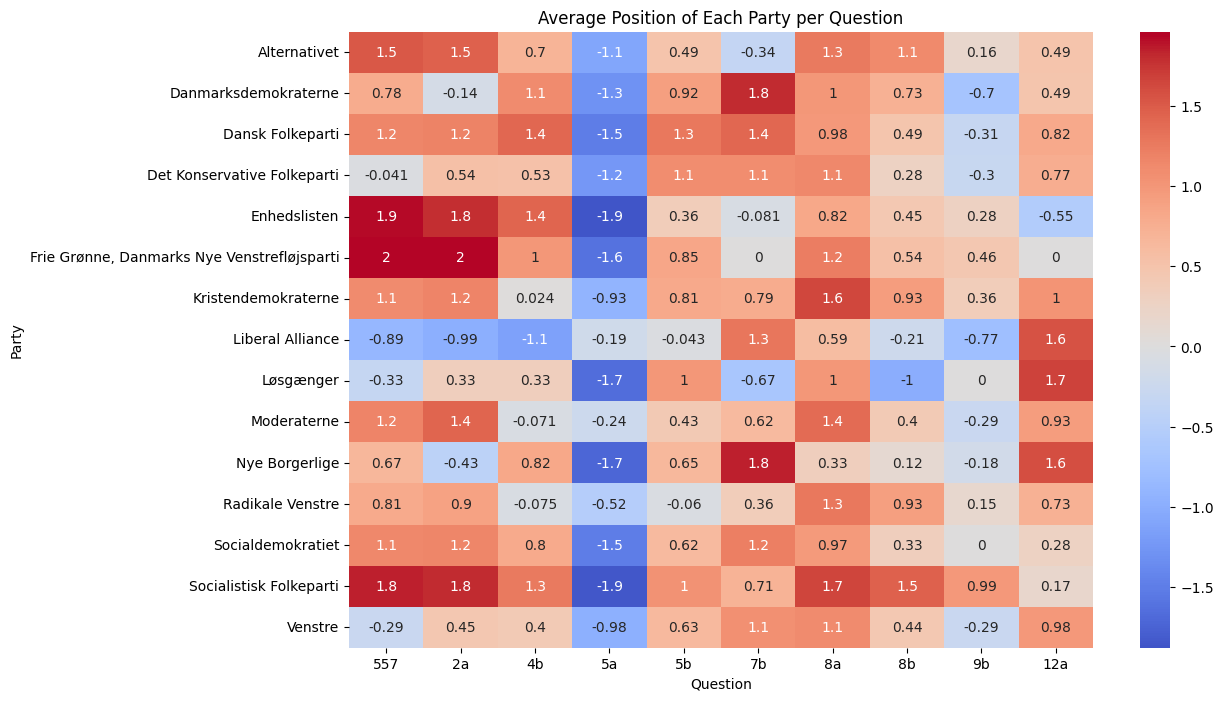

In [67]:
# Plot the data
# Heatmap to display average responses of each party for all questions
plt.figure(figsize=(12, 8))
sns.heatmap(party_averages, annot=True, cmap="coolwarm", center=0)
plt.title("Average Position of Each Party per Question")
plt.xlabel("Question")
plt.ylabel("Party")
plt.show()

### Encode Party Information

In [68]:
from sklearn.preprocessing import LabelEncoder

# Work with a copy of the alldata_cleaned DataFrame
party_answers = alldata_cleaned.copy()

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform the 'parti' column
party_answers['parti_encoded'] = label_encoder.fit_transform(party_answers['parti'])

# Create a mapping from encoded labels to original party names
party_mapping = dict(zip(party_answers['parti_encoded'], party_answers['parti']))
print("Party encoding mapping:", party_mapping)

# Now, group by 'parti_encoded' if needed, but with the encoding applied beforehand
grouped_party_answers = party_answers.groupby('parti_encoded')[filtered_question_columns]



Party encoding mapping: {9: 'Moderaterne', 13: 'Socialistisk Folkeparti', 0: 'Alternativet', 8: 'Løsgænger', 4: 'Enhedslisten', 1: 'Danmarksdemokraterne', 14: 'Venstre', 5: 'Frie Grønne, Danmarks Nye Venstrefløjsparti', 2: 'Dansk Folkeparti', 6: 'Kristendemokraterne', 7: 'Liberal Alliance', 10: 'Nye Borgerlige', 3: 'Det Konservative Folkeparti', 11: 'Radikale Venstre', 12: 'Socialdemokratiet'}


### Cluster Analysis

##### K-means & PCA

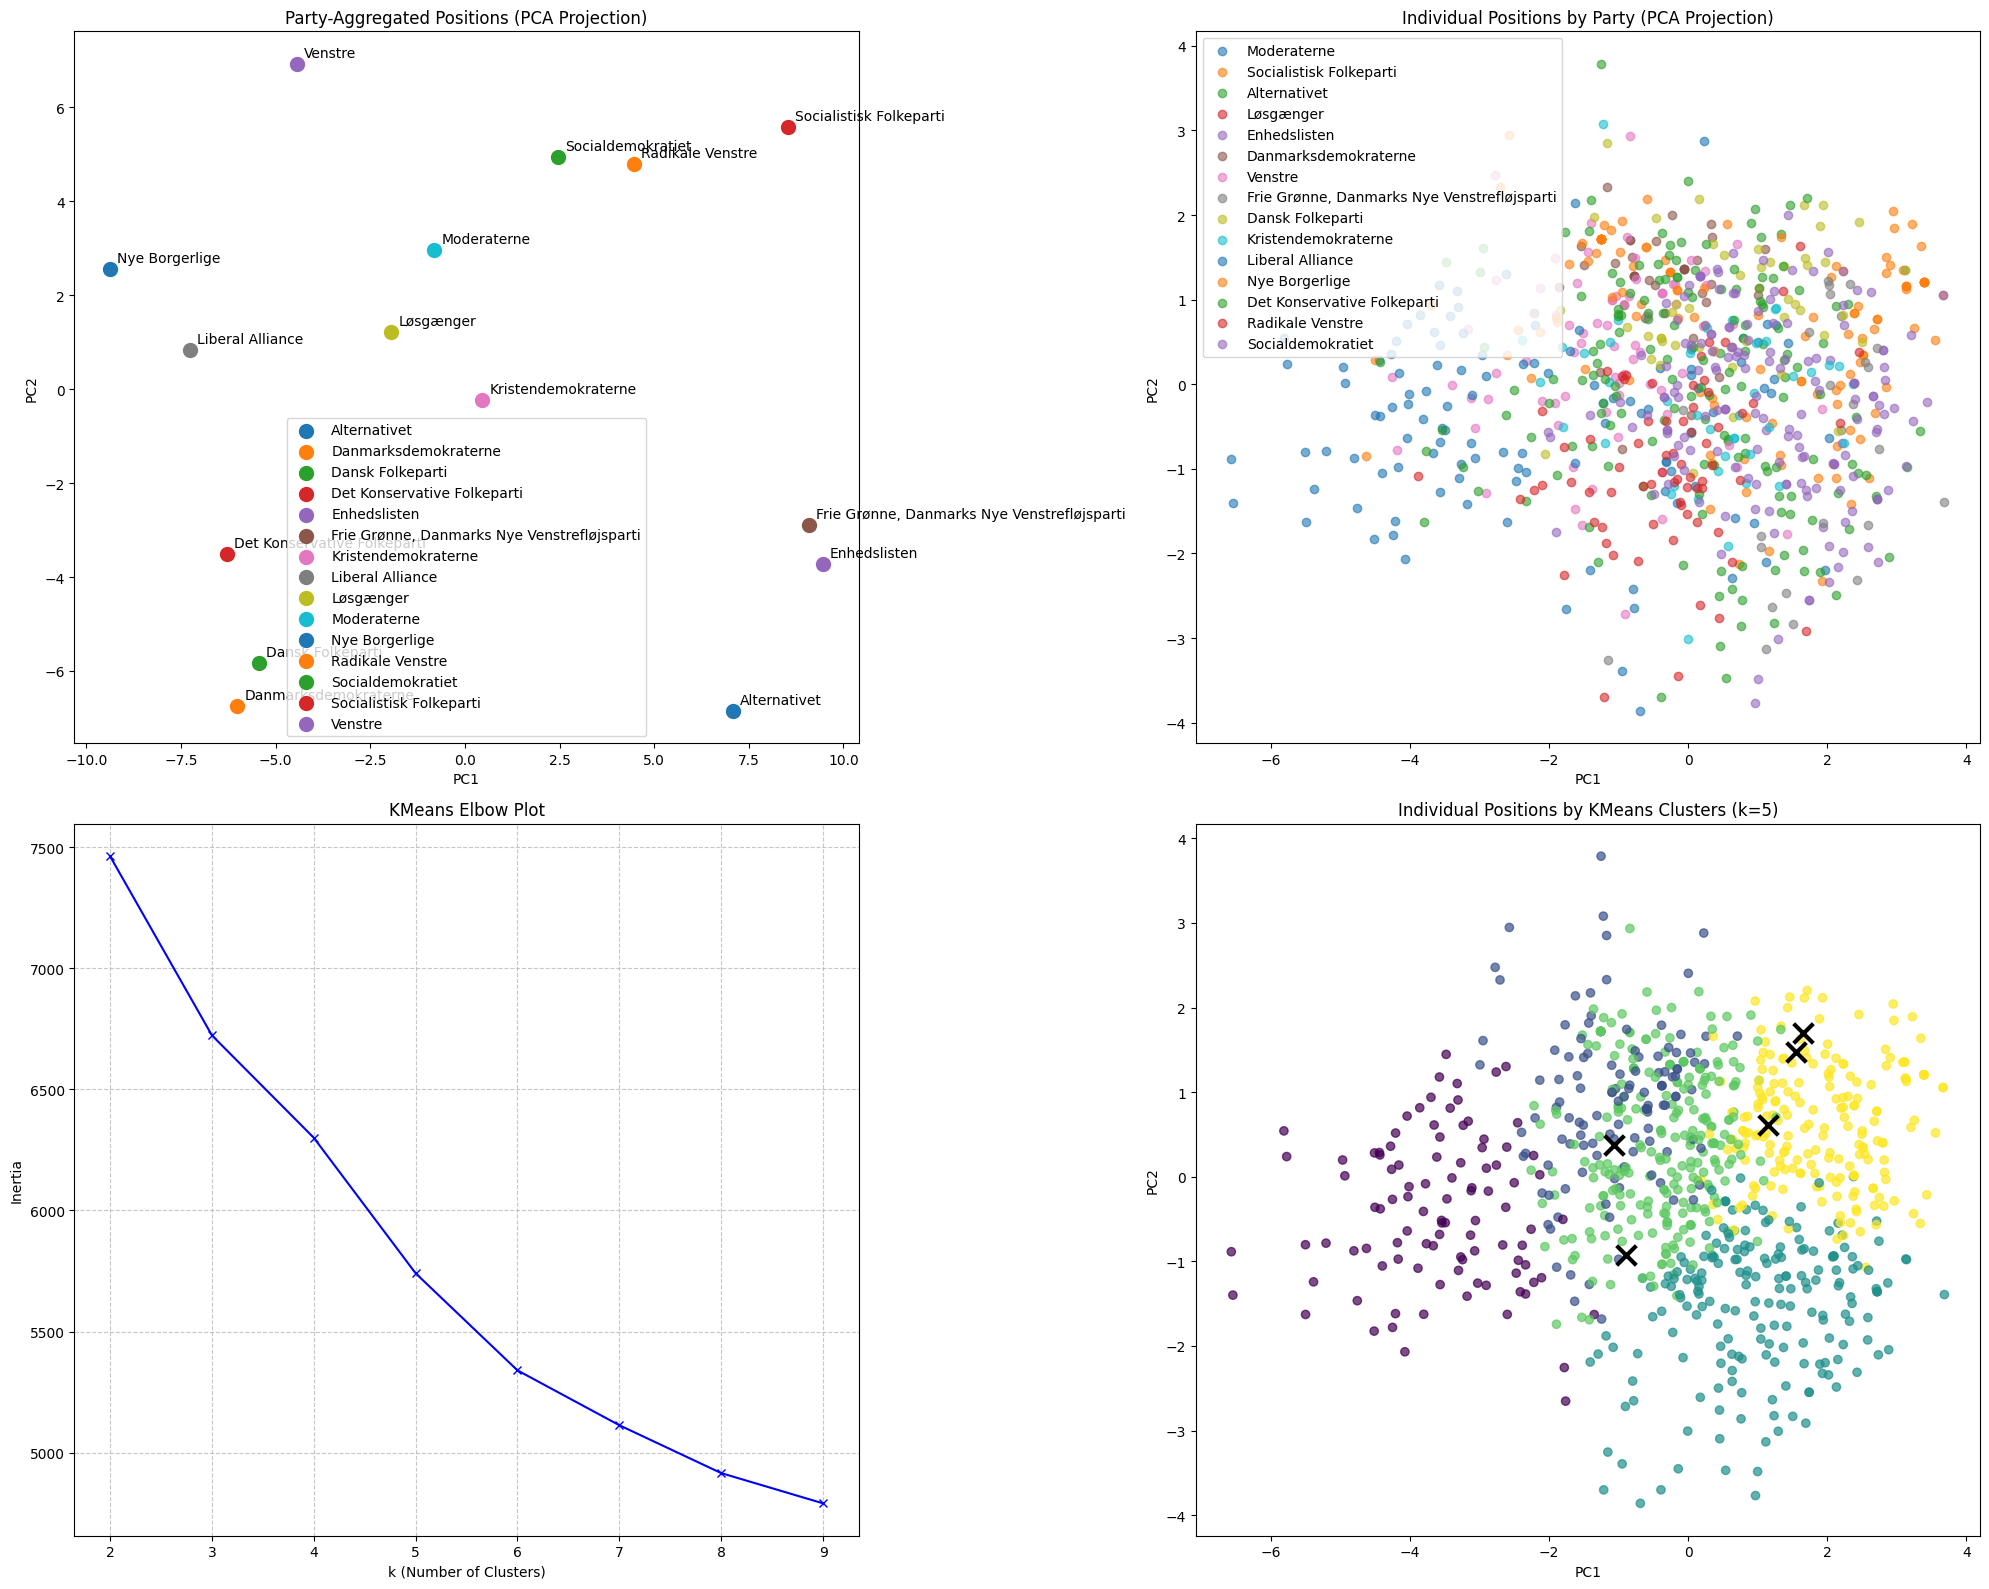

In [69]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 2x2 plot layout
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# 1. Party Positions Aggregated Before PCA
party_positions = party_answers.groupby('parti').mean()  # Aggregated by party
pca = PCA(n_components=2)
party_pca = pca.fit_transform(party_positions)

# Plot aggregated positions by party
for i, party in enumerate(party_positions.index):
    axs[0, 0].scatter(party_pca[i, 0], party_pca[i, 1], s=100, label=party)
    axs[0, 0].annotate(party, (party_pca[i, 0], party_pca[i, 1]), xytext=(5, 5), textcoords='offset points')
axs[0, 0].set_title('Party-Aggregated Positions (PCA Projection)')
axs[0, 0].set_xlabel('PC1')
axs[0, 0].set_ylabel('PC2')
axs[0, 0].legend(loc='best')

# 2. Individual Positions by Party (PCA Projection)
# Reduce the dimensionality of the individual data
individual_pca = pca.fit_transform(party_answers[filtered_question_columns])

for party in party_answers['parti'].unique():
    mask = party_answers['parti'] == party
    axs[0, 1].scatter(individual_pca[mask, 0], individual_pca[mask, 1], alpha=0.6, label=party)
axs[0, 1].set_title('Individual Positions by Party (PCA Projection)')
axs[0, 1].set_xlabel('PC1')
axs[0, 1].set_ylabel('PC2')
axs[0, 1].legend(loc='best')

# 3. KMeans Elbow Plot
inertia = []
K = range(2, 10)  # Testing a range of k values from 2 to 9

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(party_answers[filtered_question_columns])
    inertia.append(kmeans.inertia_)

# Plot inertia values to find the "elbow"
axs[1, 0].plot(K, inertia, 'bx-')
axs[1, 0].set_xlabel('k (Number of Clusters)')
axs[1, 0].set_ylabel('Inertia')
axs[1, 0].set_title('KMeans Elbow Plot')
axs[1, 0].grid(True, linestyle='--', alpha=0.7)

# 4. Individual Positions by KMeans Clusters (PCA Projection)
# Perform KMeans with an optimal number of clusters (e.g., 5)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(party_answers[filtered_question_columns])

# Plot individual positions with KMeans clusters
scatter = axs[1, 1].scatter(individual_pca[:, 0], individual_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
# Mark centroids
axs[1, 1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker='x', s=200, linewidth=3)
axs[1, 1].set_title(f'Individual Positions by KMeans Clusters (k={optimal_k})')
axs[1, 1].set_xlabel('PC1')
axs[1, 1].set_ylabel('PC2')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


##### Heiarchial Clustering

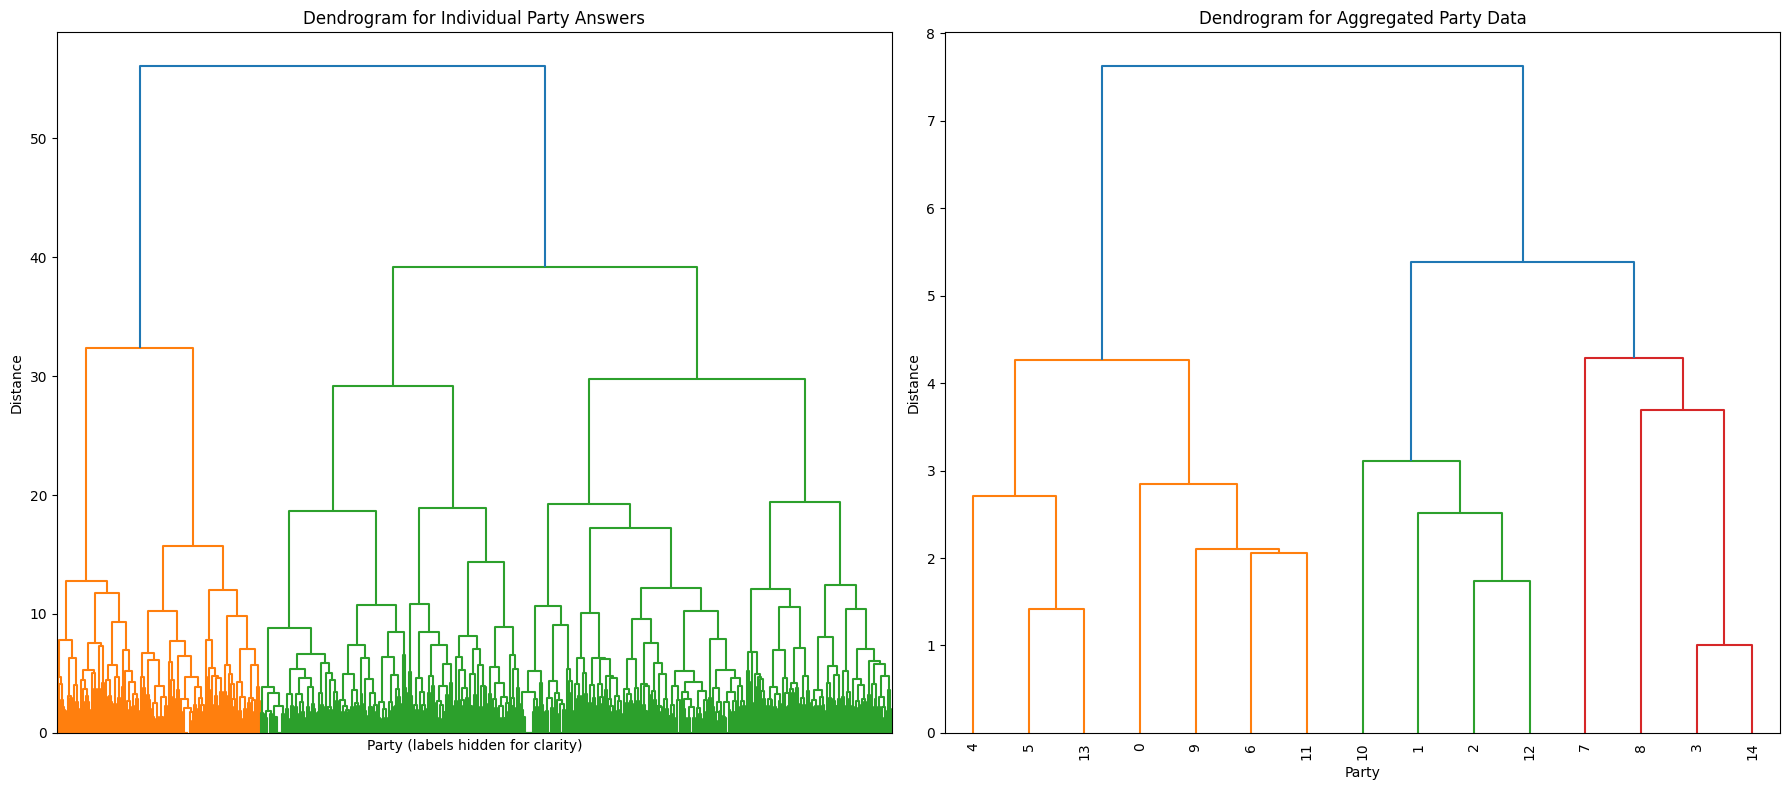

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

# Ensure 'parti_encoded' is correctly aligned for labels
labels_for_dendrogram = [party_mapping[label] for label in party_answers['parti_encoded']]

# Perform hierarchical clustering on individual party answers using numeric columns
linkage_matrix = linkage(party_answers[filtered_question_columns].select_dtypes(include='number'), method='ward')

# Aggregating party data: selecting only numeric columns for aggregation
numeric_columns = party_answers[filtered_question_columns].select_dtypes(include='number').columns
party_positions = party_answers.groupby('parti_encoded')[numeric_columns].median()

# Perform hierarchical clustering on aggregated party data
linkage_matrix_agg = linkage(party_positions, method='ward')

# Set up the figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# First subplot: Individual party answers dendrogram without labels to avoid clutter
axs[0].set_title("Dendrogram for Individual Party Answers")
dendrogram(linkage_matrix, ax=axs[0], leaf_rotation=90, leaf_font_size=8, no_labels=True)
axs[0].set_xlabel("Party (labels hidden for clarity)")
axs[0].set_ylabel("Distance")

# Second subplot: Aggregated dendrogram with party labels
axs[1].set_title("Dendrogram for Aggregated Party Data")
dendrogram(linkage_matrix_agg, labels=party_positions.index.tolist(), ax=axs[1], leaf_rotation=90, leaf_font_size=10)
axs[1].set_xlabel("Party")
axs[1].set_ylabel("Distance")

# Adjust layout to prevent overlap and improve readability
plt.tight_layout()
plt.show()

##### DBSCAN Clustering

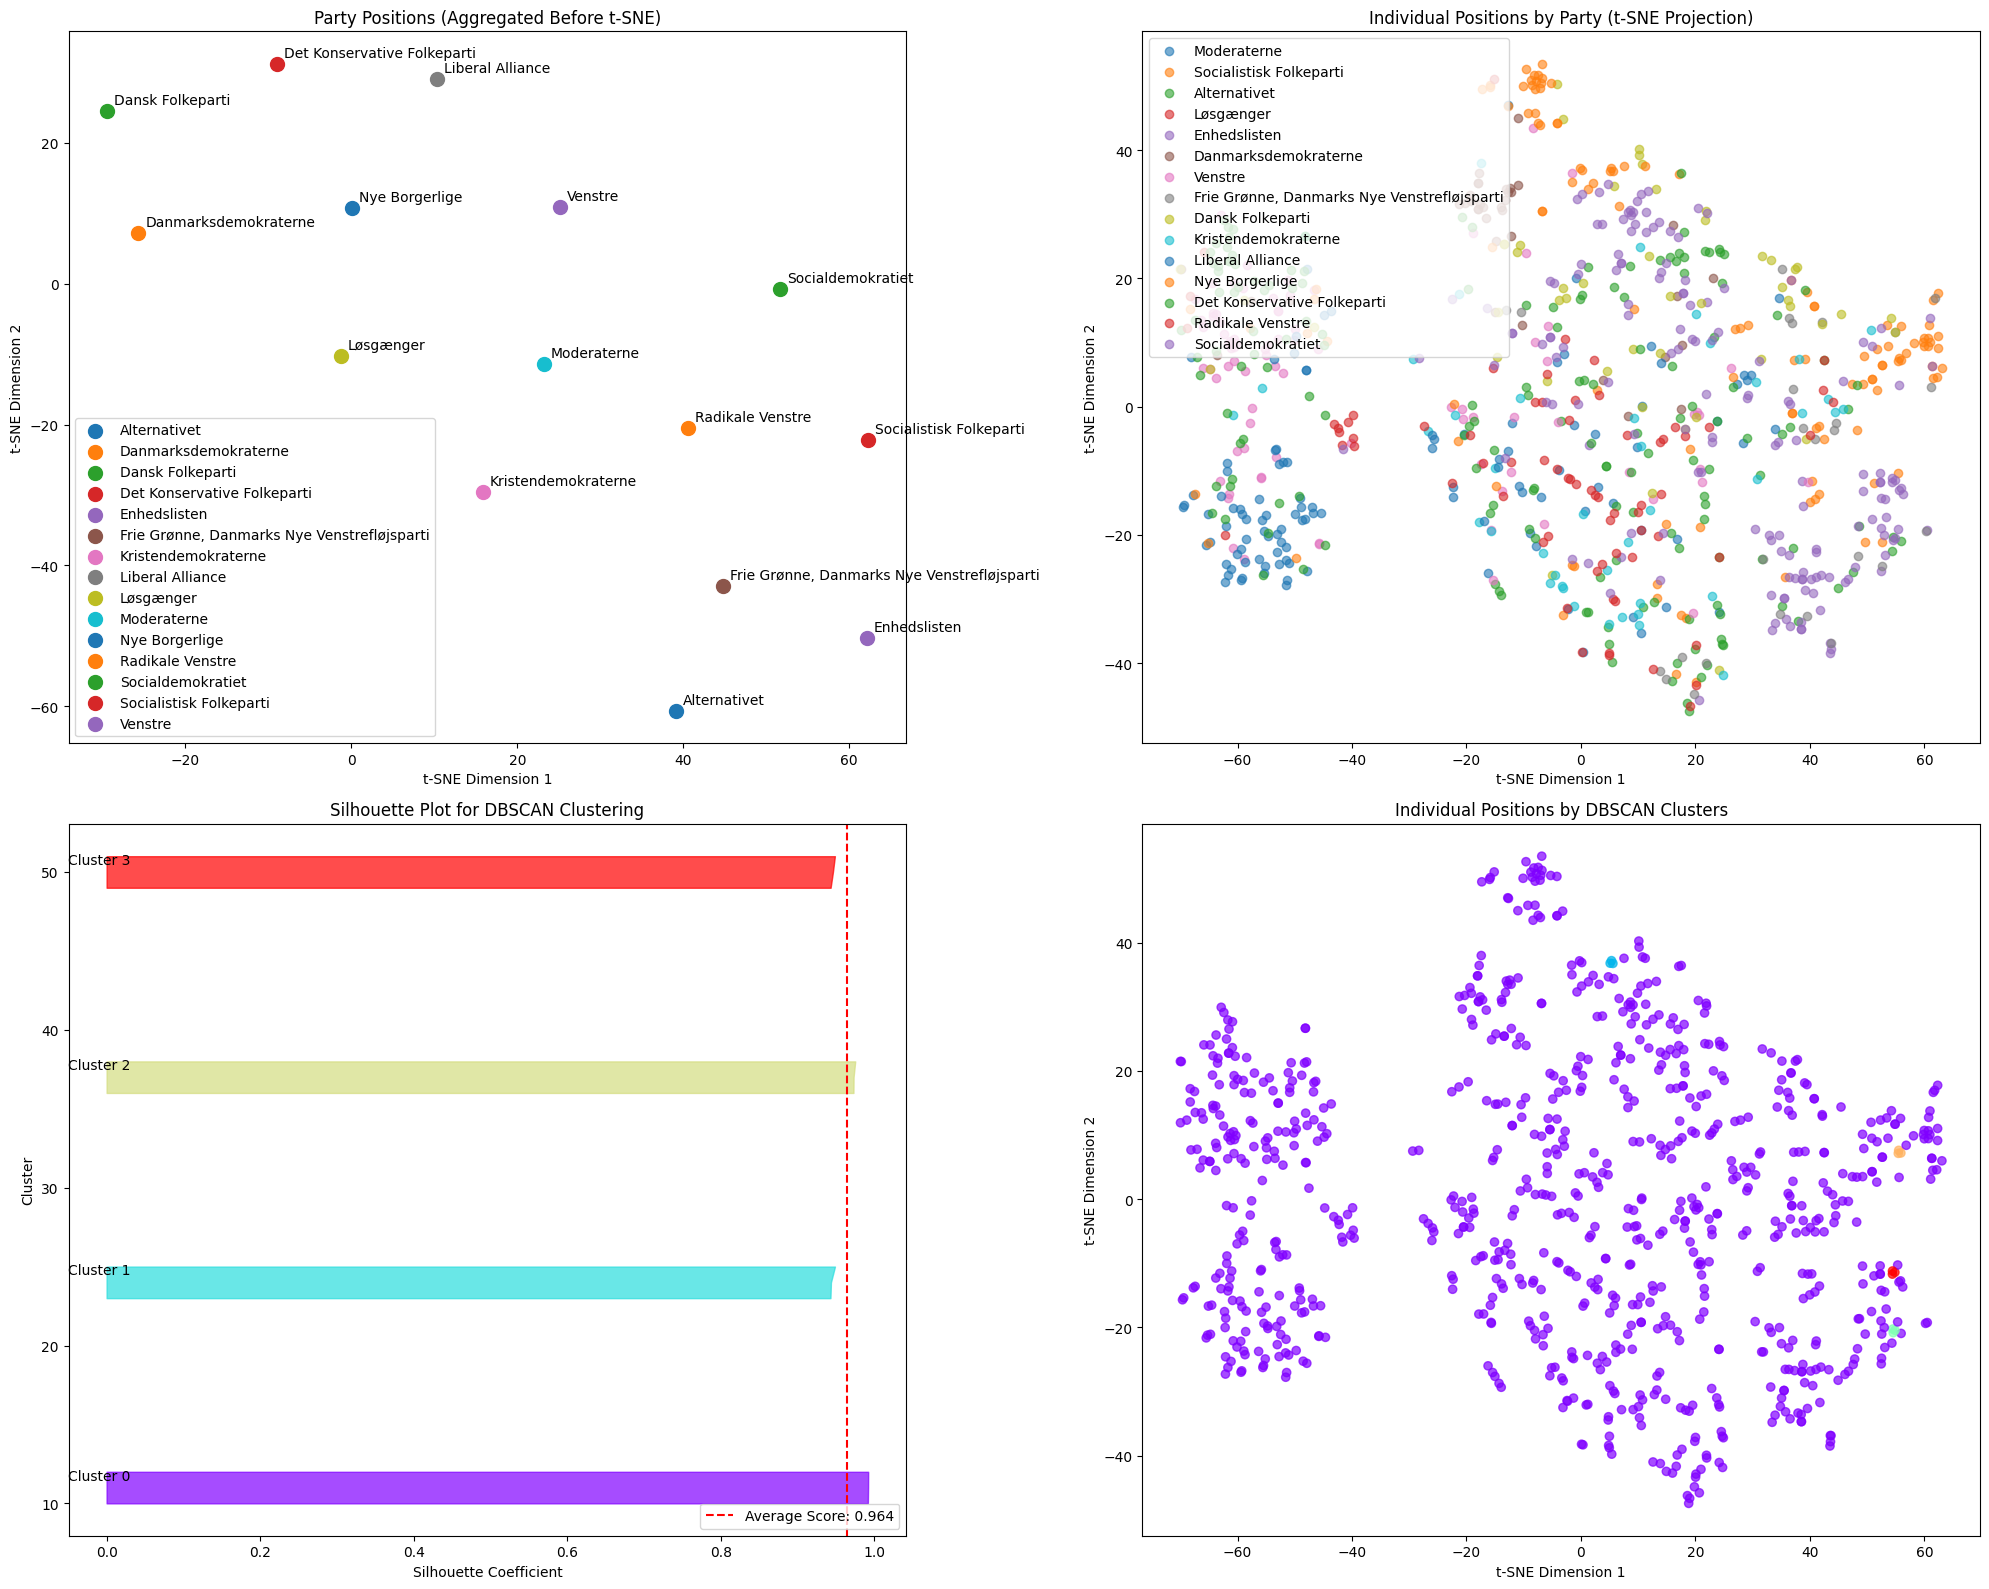

In [71]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the 2x2 plot layout
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# 1. Party-Aggregated t-SNE Positions
party_positions = party_answers.groupby('parti').median()  # Aggregated by party
tsne = TSNE(n_components=2, random_state=7, perplexity=10)
party_tsne = tsne.fit_transform(party_positions)

for i, party in enumerate(party_positions.index):
    axs[0, 0].scatter(party_tsne[i, 0], party_tsne[i, 1], s=100, label=party)
    axs[0, 0].annotate(party, (party_tsne[i, 0], party_tsne[i, 1]), xytext=(5, 5), textcoords='offset points')
axs[0, 0].set_title('Party Positions (Aggregated Before t-SNE)')
axs[0, 0].set_xlabel('t-SNE Dimension 1')
axs[0, 0].set_ylabel('t-SNE Dimension 2')
axs[0, 0].legend(loc='best')

# 2. Individual Positions by Party
individual_tsne = tsne.fit_transform(party_answers[filtered_question_columns])

for party in party_answers['parti'].unique():
    mask = party_answers['parti'] == party
    axs[0, 1].scatter(individual_tsne[mask, 0], individual_tsne[mask, 1], alpha=0.6, label=party)
axs[0, 1].set_title('Individual Positions by Party (t-SNE Projection)')
axs[0, 1].set_xlabel('t-SNE Dimension 1')
axs[0, 1].set_ylabel('t-SNE Dimension 2')
axs[0, 1].legend(loc='best')

# 3. Silhouette Plot for DBSCAN
# Run DBSCAN and calculate silhouette scores (excluding outliers)
dbscan = DBSCAN(eps=0.5, min_samples=3)  # Adjust hyperparameters as needed
clusters = dbscan.fit_predict(individual_tsne)
mask = clusters != -1  # Exclude noise points (-1)

if np.unique(clusters[mask]).size > 1:  # Ensure more than one cluster is present for silhouette calculation
    silhouette_vals = silhouette_samples(individual_tsne[mask], clusters[mask])
    silhouette_avg = silhouette_score(individual_tsne[mask], clusters[mask])

    y_lower = 10
    unique_clusters = np.unique(clusters[mask])
    color_map = plt.cm.rainbow

    for cluster in unique_clusters:
        cluster_silhouette_vals = silhouette_vals[clusters[mask] == cluster]
        cluster_silhouette_vals.sort()
        
        size_cluster = len(cluster_silhouette_vals)
        y_upper = y_lower + size_cluster

        color = color_map(cluster / unique_clusters.max())
        axs[1, 0].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
        
        axs[1, 0].text(-0.05, y_lower + 0.5 * size_cluster, f'Cluster {cluster}')
        y_lower = y_upper + 10

    axs[1, 0].axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Average Score: {silhouette_avg:.3f}')
    axs[1, 0].set_title('Silhouette Plot for DBSCAN Clustering')
    axs[1, 0].set_xlabel('Silhouette Coefficient')
    axs[1, 0].set_ylabel('Cluster')
    axs[1, 0].legend(loc='lower right')
else:
    axs[1, 0].text(0.5, 0.5, 'Silhouette score not available with single cluster', ha='center', va='center')
    axs[1, 0].set_title('Silhouette Plot for DBSCAN Clustering')
    axs[1, 0].set_xlabel('Silhouette Coefficient')
    axs[1, 0].set_ylabel('Cluster')

# 4. Individual Positions by DBSCAN Clusters (t-SNE Projection)
scatter = axs[1, 1].scatter(individual_tsne[:, 0], individual_tsne[:, 1], c=clusters, cmap='rainbow', alpha=0.7)
axs[1, 1].set_title('Individual Positions by DBSCAN Clusters')
axs[1, 1].set_xlabel('t-SNE Dimension 1')
axs[1, 1].set_ylabel('t-SNE Dimension 2')

# Adjust layout and display
plt.tight_layout()
plt.show()
